In [ ]:
"""
Absolute vs Relative Time Index Demo

This notebook demonstrates the AbsoluteRelativeIndex, which handles trial-based 
data where each trial has both absolute time (experiment time) and relative time
(time within the trial).
"""
import matplotlib.pyplot as plt
import numpy as np

from linked_indices import AbsoluteRelativeIndex
from linked_indices.example_data import trial_based_dataset

In [ ]:
# Generate example trial-based data
# 5 trials, each 10 seconds long, sampled at 100 Hz
ds = trial_based_dataset(n_trials=5, trial_length=10.0, sample_rate=100)
ds


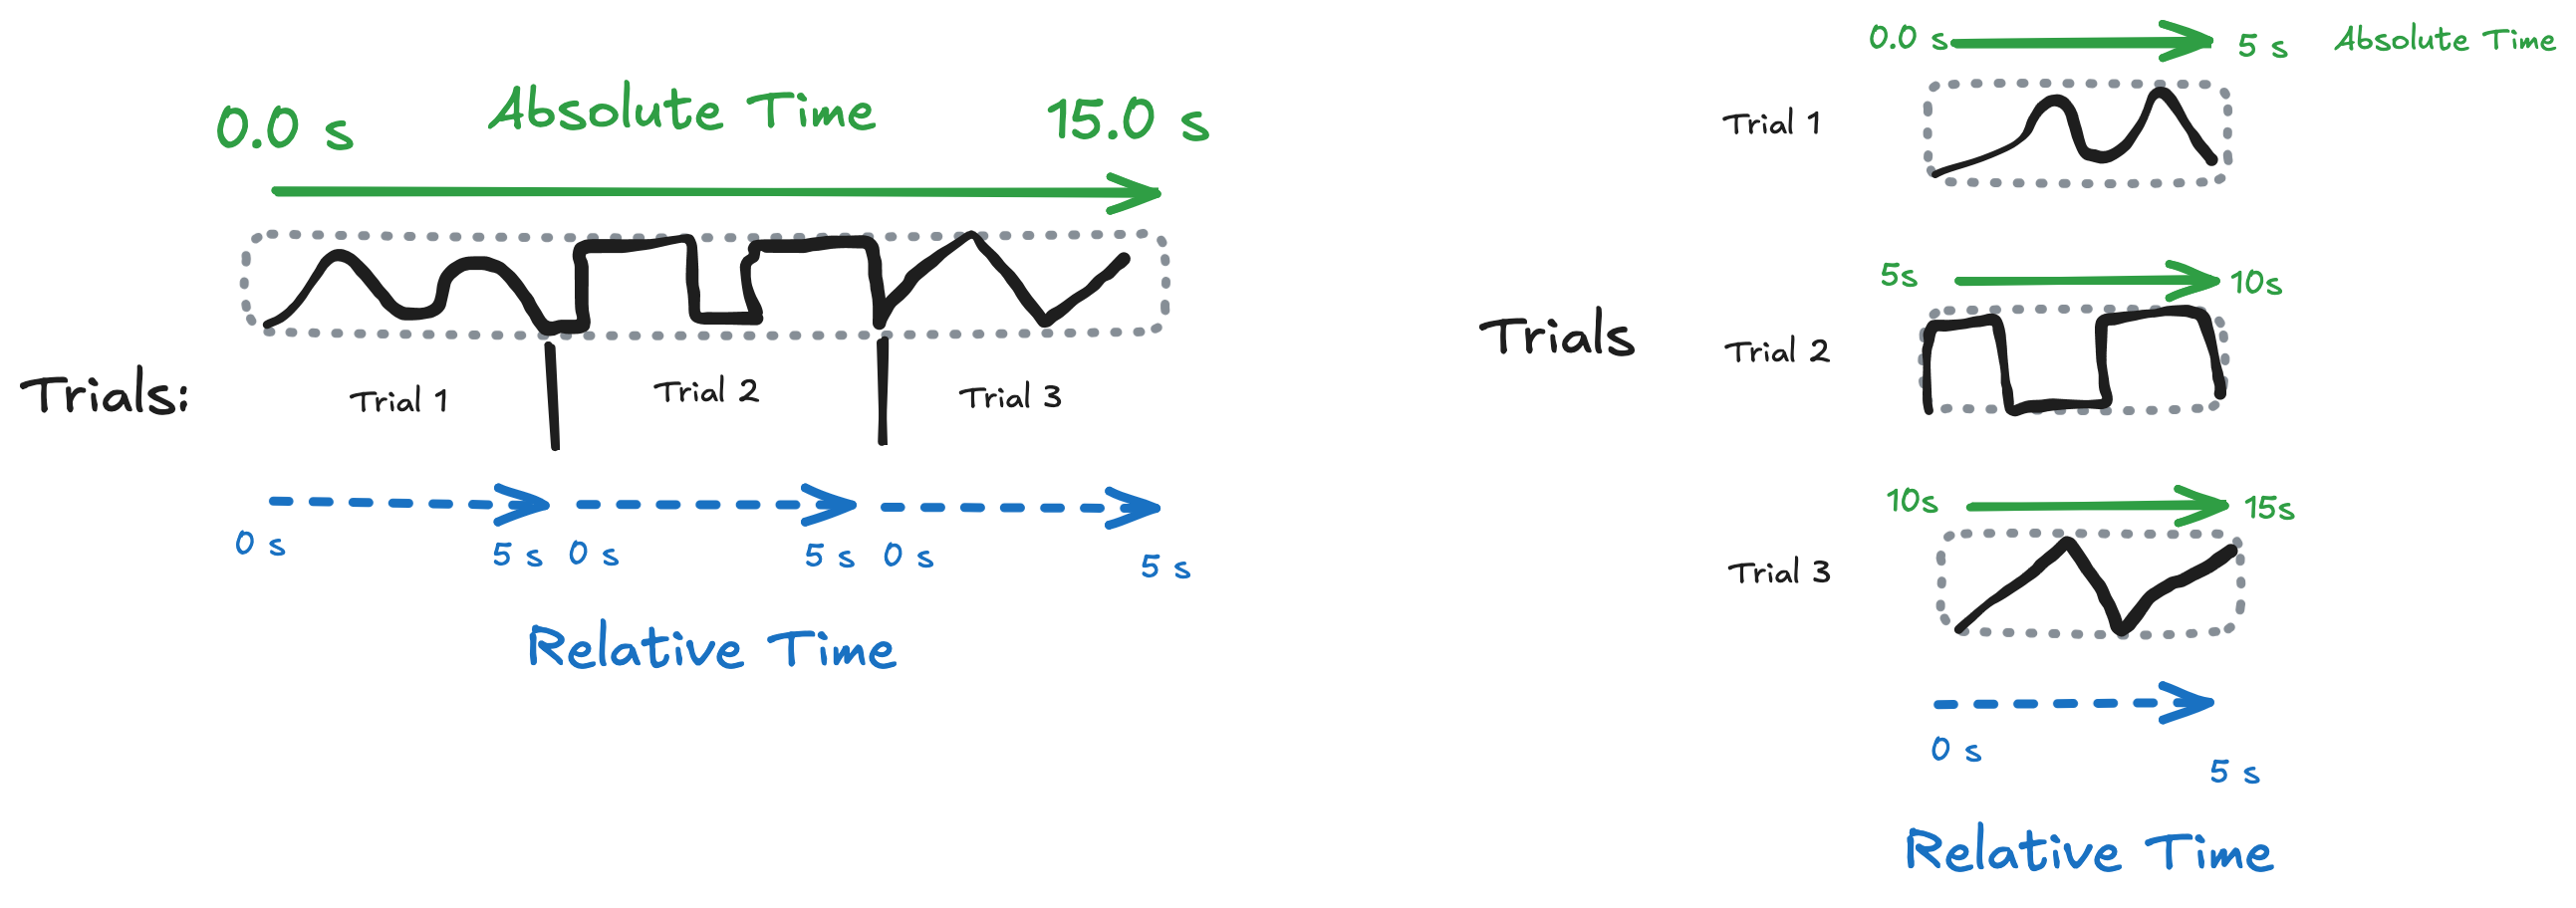

## Concept: Absolute vs Relative Time

In trial-based experiments, data is often organized as:
- **1D view**: A single continuous stream indexed by absolute time
- **2D view**: Multiple trials, each with relative time within the trial

The `AbsoluteRelativeIndex` lets you work with both views seamlessly:

```
1D View (absolute time):
|-------- Trial 1 --------|-------- Trial 2 --------|-------- Trial 3 --------|
0s                        10s                       20s                       30s

2D View (trial × rel_time):
         rel_time:  0s        5s        10s
Trial 1:  |---------|---------|  (abs: 0-10s)
Trial 2:  |---------|---------|  (abs: 10-20s)
Trial 3:  |---------|---------|  (abs: 20-30s)
```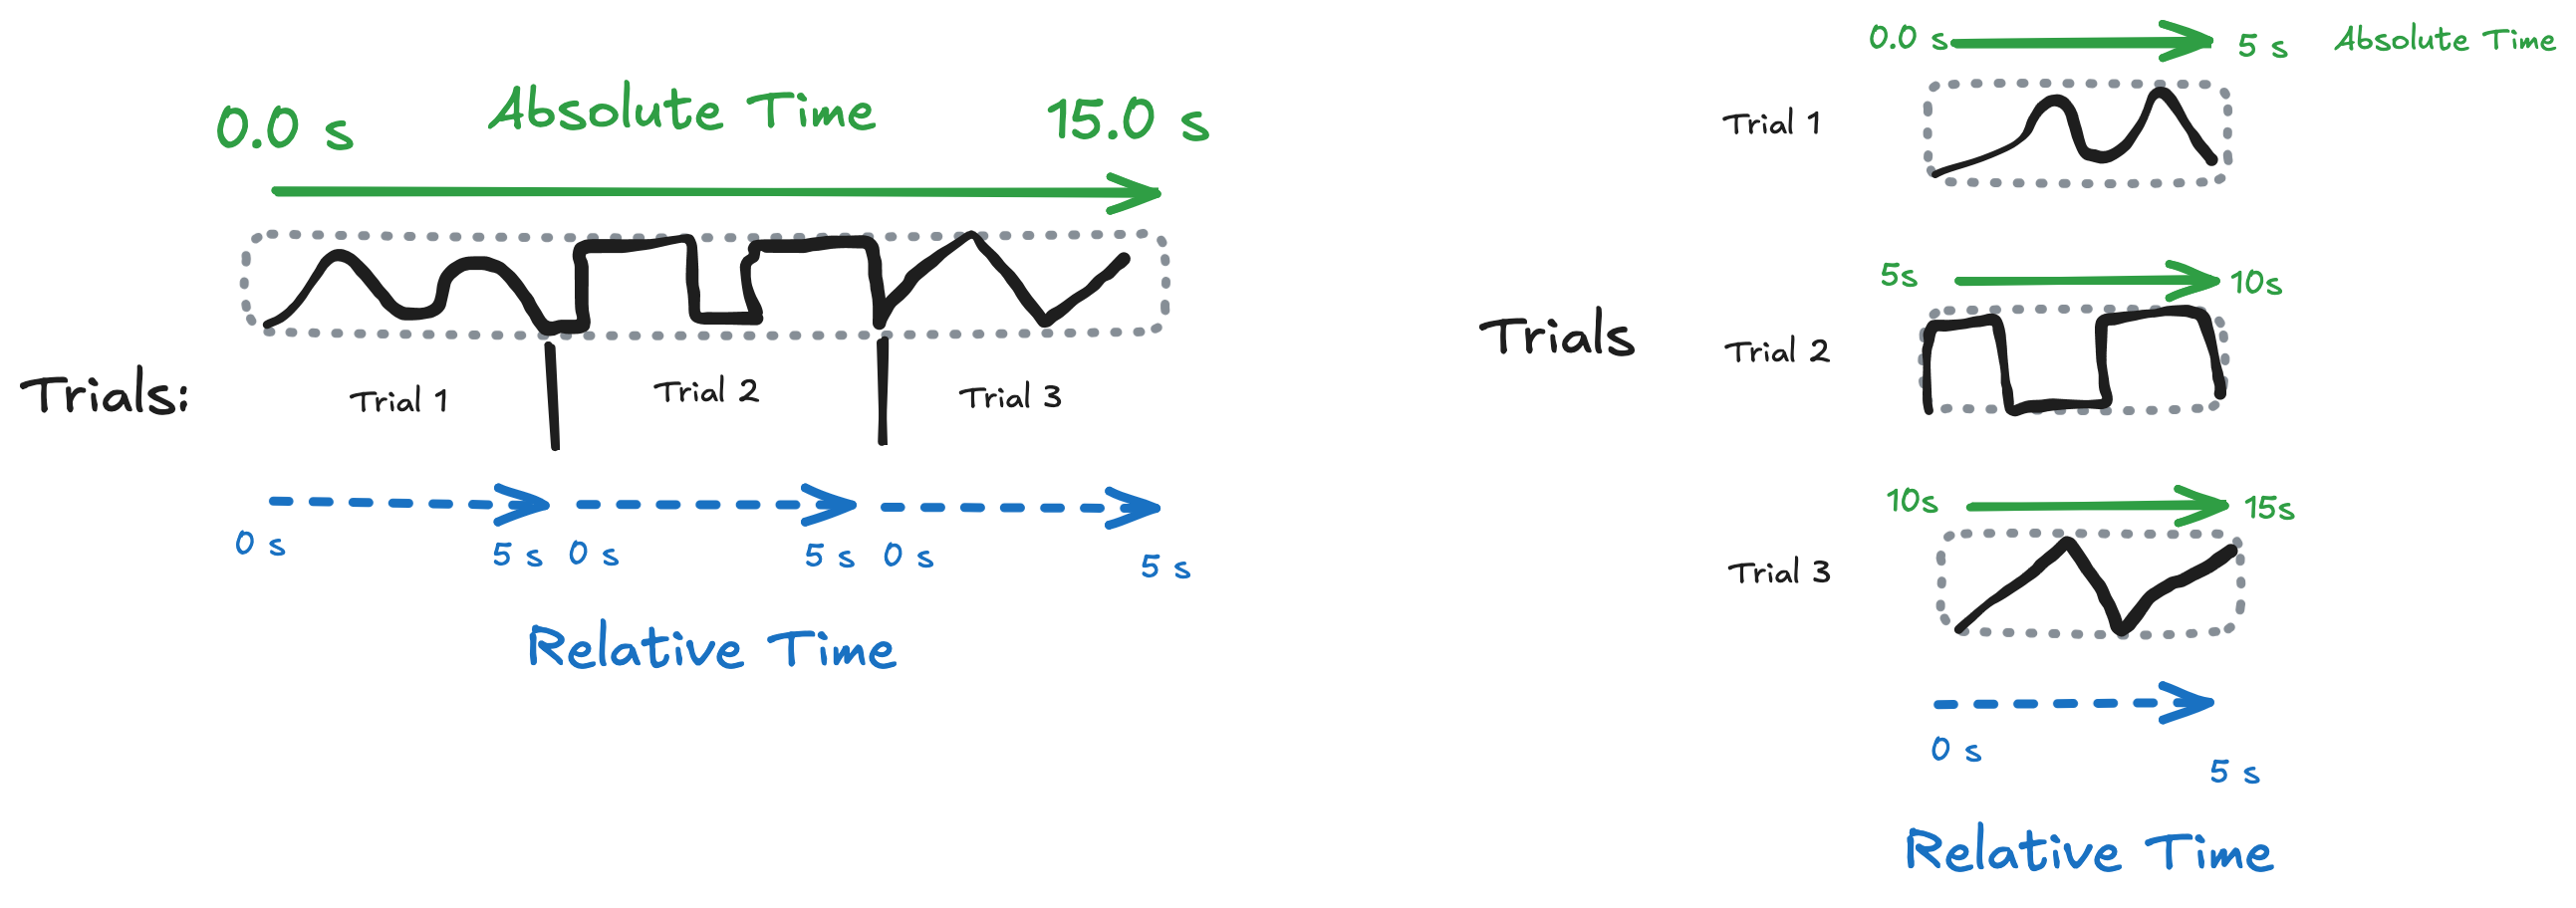

In [ ]:
# Create a conceptual diagram of the data structure
fig, axes = plt.subplots(2, 1, figsize=(14, 5), gridspec_kw={"height_ratios": [1, 2]})

# 1D view - continuous data
ax1 = axes[0]
colors = plt.cm.tab10(np.linspace(0, 1, 5))
for i in range(5):
    ax1.axvspan(i * 10, (i + 1) * 10, alpha=0.3, color=colors[i], label=f"Trial {i}")
    ax1.annotate(
        f"Trial {i}", ((i + 0.5) * 10, 0.5), ha="center", fontsize=10, fontweight="bold"
    )

ax1.set_xlim(0, 50)
ax1.set_ylim(0, 1)
ax1.set_xlabel("Absolute Time (s)", fontsize=12)
ax1.set_title(
    "1D View: Continuous Data with Absolute Time", fontsize=14, fontweight="bold"
)
ax1.set_yticks([])

# Add arrows for absolute time
ax1.annotate(
    "",
    xy=(0, -0.1),
    xytext=(50, -0.1),
    arrowprops=dict(arrowstyle="<->", color="green", lw=2),
    annotation_clip=False,
)
ax1.text(
    25,
    -0.25,
    "abs_time: 0 → 50s",
    ha="center",
    fontsize=10,
    color="green",
    transform=ax1.get_xaxis_transform(),
)

# 2D view - trials stacked
ax2 = axes[1]
trial_height = 0.8
for i in range(5):
    y_base = 4 - i  # Stack from top to bottom
    ax2.add_patch(
        plt.Rectangle(
            (0, y_base),
            10,
            trial_height,
            facecolor=colors[i],
            edgecolor="black",
            alpha=0.5,
        )
    )
    ax2.text(
        -0.5,
        y_base + trial_height / 2,
        f"Trial {i}",
        ha="right",
        va="center",
        fontsize=10,
        fontweight="bold",
    )

    # Add abs_time range annotation
    ax2.text(
        10.5,
        y_base + trial_height / 2,
        f"abs: {i * 10}-{(i + 1) * 10}s",
        ha="left",
        va="center",
        fontsize=9,
        color="green",
    )

# Add rel_time axis
ax2.set_xlim(-1, 13)
ax2.set_ylim(-0.5, 5.5)
ax2.set_xlabel("Relative Time (s)", fontsize=12)
ax2.set_title("2D View: Trials × Relative Time", fontsize=14, fontweight="bold")
ax2.set_yticks([])

# Add arrows for rel_time
ax2.annotate(
    "",
    xy=(0, -0.3),
    xytext=(10, -0.3),
    arrowprops=dict(arrowstyle="<->", color="blue", lw=2),
    annotation_clip=False,
)
ax2.text(
    5,
    -0.5,
    "rel_time: 0 → 10s (same for all trials)",
    ha="center",
    fontsize=10,
    color="blue",
)

plt.tight_layout()
plt.suptitle(
    "AbsoluteRelativeIndex: Two Views of Trial-Based Data",
    y=1.02,
    fontsize=16,
    fontweight="bold",
)

In [ ]:
# The abs_time coordinate is 2D: maps (trial, rel_time) -> absolute time
print(f"abs_time shape: {ds.abs_time.shape}")
print(f"trial_onset values: {ds.trial_onset.values}")
ds.abs_time

In [ ]:
# Apply the AbsoluteRelativeIndex
# First drop the default indexes, then set our custom index
ds_indexed = ds.drop_indexes(["trial", "rel_time"]).set_xindex(
    ["abs_time", "trial", "rel_time"],
    AbsoluteRelativeIndex,
)
ds_indexed

In [ ]:
# Select by absolute time - finds the correct (trial, rel_time) point
# abs_time=25 is in trial_2 (which spans 20-30s), at rel_time=5
result = ds_indexed.sel(abs_time=25.0, method="nearest")
print(f"Selected trial: {result.trial.values}")
print(f"Selected rel_time: {float(result.rel_time):.2f}")
print(f"abs_time at selection: {float(result.abs_time):.2f}")
result

In [ ]:
# Select a range of absolute time that spans multiple trials
# abs_time 15-25 spans trial_1 (10-20) and trial_2 (20-30)
result_range = ds_indexed.sel(abs_time=slice(15.0, 25.0))
print(f"Trials selected: {list(result_range.trial.values)}")
print(f"Number of rel_time points: {result_range.sizes['rel_time']}")
result_range

In [ ]:
# Select by trial - get all data for a specific trial
trial_data = ds_indexed.sel(trial="trial_2")
print(
    f"Trial 2 abs_time range: {float(trial_data.abs_time.min()):.1f} - {float(trial_data.abs_time.max()):.1f}"
)
trial_data

In [ ]:
# Select by relative time - same relative time across all trials
# This is useful for comparing the same timepoint within each trial
rel_time_data = ds_indexed.sel(rel_time=5.0, method="nearest")
print(f"Selected rel_time: {float(rel_time_data.rel_time):.2f}")
print(f"abs_time values at this rel_time: {rel_time_data.abs_time.values}")
rel_time_data

In [ ]:
# Visualize the data
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Plot as 1D with absolute time
for i, trial in enumerate(ds_indexed.trial.values):
    trial_slice = ds_indexed.sel(trial=trial)
    # Flatten the abs_time since it's still 2D after selection
    abs_time_flat = trial_slice.abs_time.values.flatten()
    data_flat = trial_slice.data.values.flatten()
    axes[0].plot(abs_time_flat, data_flat, label=trial)
axes[0].set_xlabel("Absolute Time (s)")
axes[0].set_ylabel("Signal")
axes[0].set_title("Data vs Absolute Time")
axes[0].legend(loc="upper right", ncol=5)

# Plot as 2D with relative time (all trials overlaid)
for i, trial in enumerate(ds_indexed.trial.values):
    trial_slice = ds_indexed.sel(trial=trial)
    rel_time_flat = trial_slice.rel_time.values.flatten()
    data_flat = trial_slice.data.values.flatten()
    axes[1].plot(rel_time_flat, data_flat, alpha=0.7, label=trial)
axes[1].set_xlabel("Relative Time (s)")
axes[1].set_ylabel("Signal")
axes[1].set_title("Data vs Relative Time (trials overlaid)")

plt.tight_layout()